## Fertilization_Prediction_Forecast
Using Timeseries data from soil sensors to predict the fertilization level of the soil.
Part of the dataset used in this project was published through Mendeley Data with DOI:http://doi.org/10.17632/87stbx334b.1.
While the preliminary statistical analysis for the dataset was published in Smart Agricultural Technology under title "A Novel Dataset for Wireless Soil Monitoring of a Strawberry Harvest and Respective Evaluation of Physicochemical Qualities" with DOI: http://dx.doi.org/10.1016/j.atech.2022.100055

In [1]:
#Import the libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing , linear_model
import numpy as np
import pandas as pd
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

### Developed function to be used in the code

In [2]:
#%% Developed function to be used in the code

def Forcast_Data_Plot( output_data, train_prediction_data,test_prediction_data):
    #The function used to shift the prediction timeline to allign with the actuall data
    #Output_Data: is the predictor that is used to train and test the models
    #train_prediction_data: is the train data used to train each model
    #test_prediction_data: is the test data used to test each model
    look_back=1 # to shift the prediction by 1 point to start from 1 not 0
    tst_prediction=np.empty_like(output_data)
    tst_prediction[:]=np.nan
    tst_prediction[len(train_prediction_data):len(output_data),:] = test_prediction_data
    return tst_prediction

def plot_prediction(test_data,test_prediction_data,test_index, model_name):
    #This function used to plot the prediction VS the actuall value
    #test_data: is the data used to test the model
    #test_prediction_data: is the predicted data
    # model_name: is to change the model name accourding to the need 
    plt.plot(test_index,test_data, label= "Test", color='r')
    plt.plot(test_index,test_prediction_data,label="Prediction")
    plt.title(f'{model_name} \n Test VS Prediction')
    plt.xticks(rotation=45)
    plt.xlabel('Timeline')
    plt.ylabel("EC level (ms/cm)")
    plt.legend()
    plt.show()
    
def forcast_subplot(output_data, output_data_index,prediction_data_list, score_list, model_name_list):
    #This function used to plot the subplots for all the tested models to compare the results visually
    #Output_Data: is the predictor that is used to train and test the models
    #output_data_index: is the original data index(Timeline) 
    #prediction_data_list: List with the output data from each model after being shifted to allign with the original data
    #score_list: the score for each model
    #model_name_list: list of the model name
    subplots_num=len(prediction_data_list)
    fig, axes = plt.subplots(subplots_num, 1)
    fig.supylabel('EC level')
    for i in range(subplots_num):
        axes[i].plot(output_data_index,output_data,label="Actual Values")
        axes[i].plot(output_data_index,prediction_data_list[i], color='r',label=f'Predicted Values Score:{score_list[i]:.2f}')
        axes[i].set_title(model_name_list[i])
        axes[i].legend()
        if i< subplots_num:
            axes[i].set_xticks([])
        else:
            plt.setp(axes[i].xaxis.get_majorticklabels(), rotation=45, ha='right')  # Rotate x-ticks
    plt.tight_layout()
    plt.show()

### Import the dataset


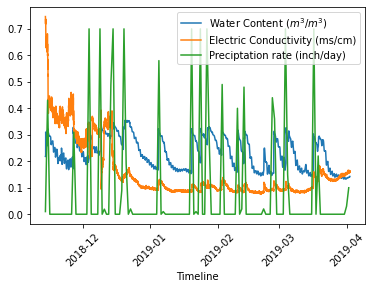

In [3]:
Data=pd.read_excel('Precipitation_Logger1.xlsx',skiprows=2,index_col=0)    
#Correct the outliers in the Precipitation data, for visualization
Data.iloc[:,6][Data.iloc[:,6]>0.7]=0.7
Data=Data.loc["2018-11-14 00:00:00":,:]
#Plot the used data
plt.figure(1)
plt.plot(Data.iloc[:,0],label='Water Content $(m^{3}/m^{3})$')
plt.plot(Data.iloc[:,2],label='Electric Conductivity (ms/cm)')
plt.plot(Data.iloc[:,6].groupby(Data.iloc[:,6].index.date).mean(),label='Preciptation rate (inch/day)')
plt.xticks(rotation=45)
plt.xlabel('Timeline')
plt.legend(loc='upper right')
plt.show()

### Preprocessing and normailze the dataset

In [4]:
#Select the models input features 
Input=Data.iloc[:,0:7].drop(columns=['mS/cm Saturation Extract EC.1','°C Soil Temperature','m³/m³ Water Content.1','°C Soil Temperature.1'])
Output=Data['mS/cm Saturation Extract EC']
Data_index=Output.index  #Save the index to be used for ploting the results
y_test_index=Output[16068:].index #Save the test data index to be used for ploting the results
#Normalizing the input/Output Data
X1= MinMaxScaler(feature_range=(0,1))
Input=X1.fit_transform(Input)
Output=Output.values.reshape(Output.shape[0],1)
X2=MinMaxScaler(feature_range=(0,1))
Output=X2.fit_transform(Output)
#Split the data into training and testing
X_train=Input[:16068,:]
X_test=Input[16068:,:]
y_train=Output[:16068,:]
y_test =Output[16068:,:]

### Build, train and test Linear Regression Model

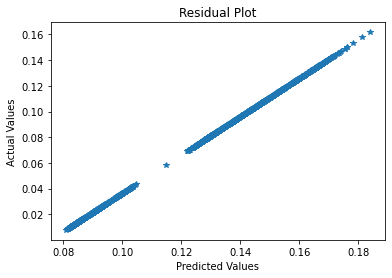

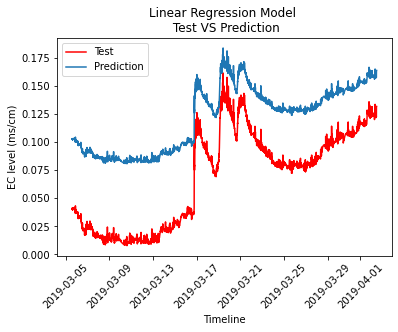

In [5]:
LR=LinearRegression().fit(X_train, y_train)
testPredict_LR= LR.predict(X_test)
trainPredict_LR= LR.predict(X_train)
LR_Score=LR.score(X_test, y_test)
MSE_LR= mean_squared_error(y_test,testPredict_LR)
#Revers the data to its original values before normalization to be used in ploting
trainPredict_LR=X2.inverse_transform(trainPredict_LR)
testPredict_LRR=X2.inverse_transform(testPredict_LR)
plt.figure(2)
plt.plot(testPredict_LRR,y_test,'*')
plt.title('Residual Plot')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()
plt.figure(3)
plot_prediction(y_test,testPredict_LRR,y_test_index, 'Linear Regression Model')
testPredictPlot_LRR=Forcast_Data_Plot(Output, trainPredict_LR,testPredict_LRR)

### Build, train and test Ridge Regression Model

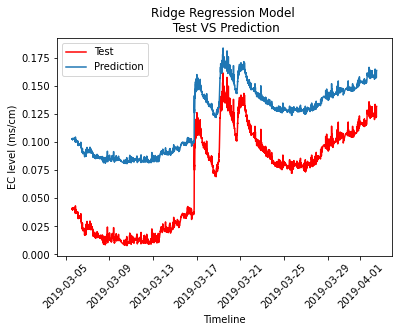

In [6]:
#%% 
RidR = linear_model.Ridge(alpha=.5).fit(X_train, y_train)
testPredict_RR= RidR.predict(X_test)
trainPredict_RR= RidR.predict(X_train)
RR_Score=RidR.score(X_test, y_test)
MSE_RR= mean_squared_error(y_test,testPredict_RR)
trainPredict_RR=X2.inverse_transform(trainPredict_RR)
testPredict_RR=X2.inverse_transform(testPredict_RR)
plt.figure(4)
plot_prediction(y_test,testPredict_RR,y_test_index, 'Ridge Regression Model')
testPredictPlot_RR=Forcast_Data_Plot(Output, trainPredict_RR,testPredict_RR)


### Build, train and test LSTM Model

In [7]:
#%% Build, train and test LSTM Model
# Reshape the dataset to fit the LSTM Model
X_train_re=X_train.reshape( X_train.shape[0],1, X_train.shape[1])
y_train_re=y_train.reshape(y_train.shape[0],1)

X_test_re=X_test.reshape( X_test.shape[0],1, X_test.shape[1])
y_test_re=y_test.reshape(y_test.shape[0],1)
print(X_train_re.shape,y_train_re.shape,X_test_re.shape,y_test_re.shape)

(16068, 1, 3) (16068, 1) (4018, 1, 3) (4018, 1)


Epoch 1/20
503/503 - 9s - loss: 0.0243 - mse: 0.0243 - val_loss: 0.0030 - val_mse: 0.0030 - 9s/epoch - 17ms/step
Epoch 2/20
503/503 - 3s - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0026 - val_mse: 0.0026 - 3s/epoch - 6ms/step
Epoch 3/20
503/503 - 3s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.0019 - val_mse: 0.0019 - 3s/epoch - 6ms/step
Epoch 4/20
503/503 - 3s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0012 - val_mse: 0.0012 - 3s/epoch - 6ms/step
Epoch 5/20
503/503 - 3s - loss: 0.0022 - mse: 0.0022 - val_loss: 6.4401e-04 - val_mse: 6.4401e-04 - 3s/epoch - 6ms/step
Epoch 6/20
503/503 - 3s - loss: 5.7943e-04 - mse: 5.7943e-04 - val_loss: 3.7113e-04 - val_mse: 3.7113e-04 - 3s/epoch - 6ms/step
Epoch 7/20
503/503 - 3s - loss: 3.9430e-04 - mse: 3.9430e-04 - val_loss: 2.8425e-04 - val_mse: 2.8425e-04 - 3s/epoch - 6ms/step
Epoch 8/20
503/503 - 4s - loss: 3.9822e-04 - mse: 3.9822e-04 - val_loss: 2.3168e-04 - val_mse: 2.3168e-04 - 4s/epoch - 7ms/step
Epoch 9/20
503/503 - 5s - loss: 3.3375e-04 - ms

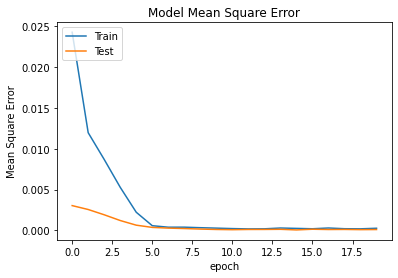

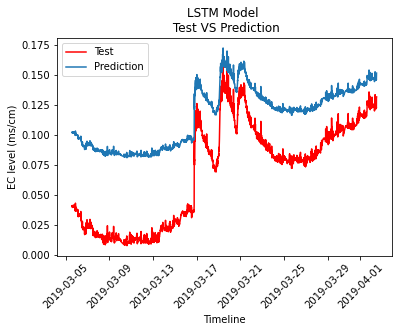

In [8]:
#Building the LSTM Model
model = Sequential()
model.add(LSTM(50,input_shape = (1,X_train_re.shape[2]), kernel_initializer='uniform',return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(5, activation='tanh'))
model.add(Dense(1,activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam' ,metrics=['mse'])
mm=model.fit(X_train_re,y_train_re,epochs=20,batch_size=32,validation_data=(X_test_re, y_test_re), verbose=2, shuffle=False)
test_acc=model.evaluate(X_test_re,y_test_re)
trainPredict_LSTM=model.predict(X_train_re)
testPredict_LSTM = model.predict(X_test_re)
MSE_LSTM= mean_squared_error(y_test_re,testPredict_LSTM)
u=((y_test_re-testPredict_LSTM)**2).sum()
v=((y_test_re-y_test_re.mean())**2).sum()
LSTM_Score=(1-(u/v))
#Plot the Model Performance 
plt.figure(5)
plt.plot(mm.history['mse'])
plt.plot(mm.history['val_mse'])
plt.legend(['Train','Test'], loc='upper left')
plt.title('Model Mean Square Error')
plt.ylabel('Mean Square Error')
plt.xlabel('epoch')
plt.show()

testPredict_LSTM=X2.inverse_transform(testPredict_LSTM)
Output=X2.inverse_transform(Output)
trainPredict_LSTM=X2.inverse_transform(trainPredict_LSTM)

plot_prediction(y_test,testPredict_LSTM, y_test_index,'LSTM Model')
testPredictPlot_LSTM=Forcast_Data_Plot(Output, trainPredict_LSTM,testPredict_LSTM)

### Ploting the timeline with the prediction to compare the 3 models

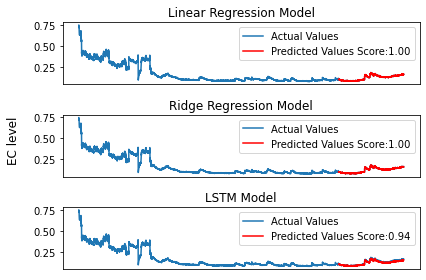

In [9]:
prediction_data_list=[testPredictPlot_LRR,testPredictPlot_RR,testPredictPlot_LSTM]
score_list=[LR_Score,RR_Score,LSTM_Score]
model_name_list=['Linear Regression Model','Ridge Regression Model','LSTM Model']
forcast_subplot(Output,Data_index,prediction_data_list, score_list, model_name_list)